In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os
import time
import tensorflow as tf

】从sp500.csv文件中读取数据，并将其存储在一个Pandas DataFrame中。Pandas是一个Python库，用于数据处理和分析。
将数据拆分为训练和测试集。它首先计算DataFrame的80％大小，然后将前80％行作为训练数据，剩余的20％行作为测试数据。
将训练和测试数据转换为numpy数组，以便在TensorFlow中使用。它使用Pandas的drop()函数删除不必要的Date和Close列，并使用numpy的array()函数将数据转换为numpy数组。

定义一个Sequential模型，该模型包含三个密集层（Dense layers），每个层都有64个神经元，激活函数为ReLU。第一个层的input_shape参数设置为(train_x.shape[1],)，其中train_x.shape[1]是训练数据中除了Date和Close列以外的列数。compile()方法指定优化器为Adam，并使用均方误差（MSE）作为损失函数。fit()方法训练模型50个epochs，批量大小为32，verbose参数为0表示不输出训练进度。
使用训练好的模型对测试数据进行预测，predict()方法返回模型对输入数据的预测值。


这行代码计算模型预测结果的均方根误差（RMSE）。首先使用TensorFlow的mean_squared_error()函数计算预测值和真实值之间的均方误差，然后使用numpy的sqrt()函数计算均方误差的平方根。最后，将RMSE打印到控制台。

In [3]:
# set batch size
batch_size = 128

# load csv data into pandas dataframe
df = pd.read_csv('sp500.csv')

# split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# convert data to numpy arrays
train_x = np.array(train_data.drop(['Date', 'Close'], axis=1))
train_y = np.array(train_data['Close'])
test_x = np.array(test_data.drop(['Date', 'Close'], axis=1))
test_y = np.array(test_data['Close'])


In [12]:
# build and train model on CPU
start_time = time.time()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(train_x.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(train_x, train_y, epochs=50, batch_size=128, verbose=0)

end_time = time.time()
cpu_time = end_time - start_time
print('CPU Time:', cpu_time)

CPU Time: 8.383921146392822


In [13]:
# set environment variables to use multiple GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

# load csv data into pandas dataframe
df = pd.read_csv('sp500.csv')

# split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# convert data to numpy arrays
train_x = np.array(train_data.drop(['Date', 'Close'], axis=1))
train_y = np.array(train_data['Close'])
test_x = np.array(test_data.drop(['Date', 'Close'], axis=1))
test_y = np.array(test_data['Close'])

# define multi-GPU strategy
strategy = tf.distribute.MirroredStrategy()

# define model inside strategy scope
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(train_x.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

# create tensorflow dataset for training data
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.batch(batch_size)

# train model on multiple GPUs
epochs = 50
steps_per_epoch = len(train_x) // batch_size

with strategy.scope():
    start_time = time.time()
    model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=0)
    end_time = time.time()
    gpu_time = end_time - start_time

    

   
print('GPU Time:', gpu_time)





INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
GPU Time: 4.145174503326416


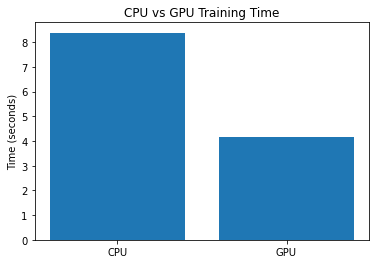

In [14]:
import matplotlib.pyplot as plt
# plot bar chart
labels = ['CPU', 'GPU']
times = [cpu_time, gpu_time]
plt.bar(labels, times)
plt.ylabel('Time (seconds)')
plt.title('CPU vs GPU Training Time')

plt.show()